<a href="https://colab.research.google.com/github/KKobuszewski/MotionTracking/blob/main/Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.interpolate


# image processing
import cv2
from PIL import ImageGrab
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# connect to google drive
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


# Współrzędne na obrazku a współrzędne rzeczywiste

By można było wykorzystać obraz z kamery do odczytania odległości przebytej

https://markhedleyjones.com/projects/calibration-checkerboard-collection

https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html



## Wczytanie obrazu kontrolnego

<class 'numpy.ndarray'>
(2256, 4000, 3)


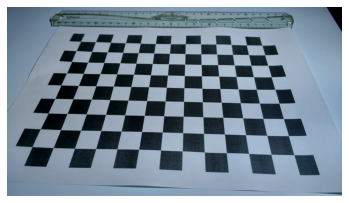

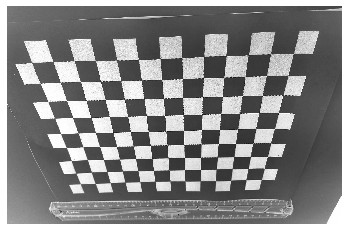

In [ ]:
img_color = cv2.imread('/content/drive/MyDrive/Szkoła Zaleskie/Ciekawostki/Motion tracking/calibration_example.jpg',cv2.IMREAD_COLOR)
#img_color = cv2.imread('/content/drive/MyDrive/Szkoła Zaleskie/Ciekawostki/Motion tracking/calib_pattern.jpg',cv2.IMREAD_COLOR)
print(type(img_color))
print(img_color.shape)

#plt.imshow(img_color[:,:,0])
plt.imshow(img_color)
plt.axis("off")
plt.show()

# make grayscale
img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
plt.pcolor(img_gray,cmap='binary')
plt.axis("off")
plt.show()

## Znalezienie punktów na planszy kalibracyjnej

In [ ]:
def find_chessboard_pts(img_color,nx=13,ny=9,dx=2.0):
  """
  """
  # get greyscale image
  img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

  # find reference points on image
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
  ret, corners_img = cv2.findChessboardCorners(img_gray, (13,9), None)
  corners_img = cv2.cornerSubPix(img_gray,corners_img, (11,11), (-1,-1), criteria)

  return corners_img

def chessboard_reference_pts(nx=13,ny=9,dx=2.0):
  """
  """
  # create array with real coordinates grid
  x_real = np.linspace(0,nx*dx,nx,endpoint=False)
  y_real = np.linspace(0,ny*dx,ny,endpoint=False)
  corners_real = np.zeros([nx*ny,1,3],dtype=np.float32)
  for ix in range(corner_x.shape[0]//nx):
    corners_real[ix*nx:(ix+1)*nx,0,0] = x_real[:]
  for iy in range(nx):
    corners_real[iy::nx,0,1] = y_real[:]

  return corners_real


def calibrate_single_frame(img_color,nx=13,ny=9,dx=2.0):
  """
  """
  # get greyscale image
  img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

  # find reference points on image
  corners_img  = find_chessboard_pts(img_color,nx=nx,ny=ny,dx=dx)

  # get reference points in reality
  corners_real = chessboard_reference_pts(nx=nx,ny=ny,dx=dx)

  # find transformation
  objpoints = [corners_real];
  imgpoints = [corners_img];
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)

  # improve camera matrix
  w,h = img_gray.shape[::-1]
  newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

  return corners_img, corners_real, mtx, dist, rvecs, tvecs, newcameramtx, roi


def undistort_image(img_gray, mtx, dist, newcameramtx, roi):
  # undistort and refit image
  img_undst = cv2.undistort(img_gray, mtx, dist, None, newcameramtx)
  x, y, w, h = roi
  img_undst = img_undst[y:y+h, x:x+w]
  return img_undst

def image_coords_interp(img_color,nx=13,ny=9,dx=2.0):
  """
  """
  # get greyscale image
  img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

  # find reference points on image
  corners_img  = find_chessboard_pts(img_color,nx=nx,ny=ny,dx=dx)

  # get reference points in reality
  corners_real = chessboard_reference_pts(nx=nx,ny=ny,dx=dx)

  # find interpolators
  xRBF = scipy.interpolate.RBFInterpolator(corners_img[:,0,:], corners_real[:,0,0])
  yRBF = scipy.interpolate.RBFInterpolator(corners_img[:,0,:], corners_real[:,0,1])

  return xRBF, yRBF

True
<class 'numpy.ndarray'> (117, 1, 2)
<class 'numpy.ndarray'> (117, 1, 2)


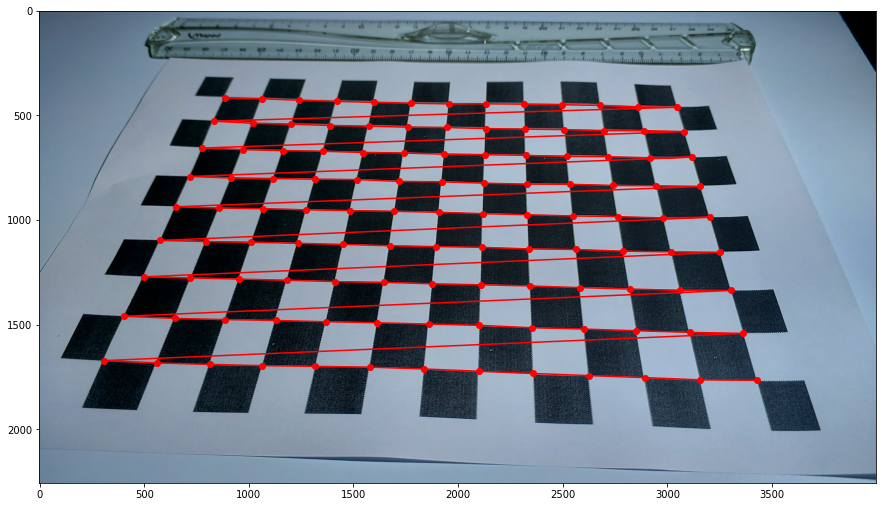

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(img_gray, (13,9), None)
print(ret)
corners2 = cv2.cornerSubPix(img_gray,corners, (11,11), (-1,-1), criteria)
print( type(corners), corners.shape )
print( type(corners2), corners2.shape )

corner_x = corners[:,:,0]
corner_y = corners[:,:,1]
npts = np.linspace(1,corner_x.shape[0],corner_x.shape[0],endpoint=True)

plt.figure(figsize=[15.,15.])
plt.imshow(img_color)
plt.plot(corner_x,corner_y,marker='o',color='r')
#plt.axis("off")
plt.show()

## Porównanie współrzędnych punktów w pikselach i w rzeczywistości

Wykorzystajmy teraz wiedzę, że w rzeczywistości bok kwadratu szachownicy ma 2 cm.

Narysujmy współrzędną x punktu w pikselach na jednej osi wykresu i odpowiadającą jej rzeczywistą współrzędną x punktu w cm. Zakładamy, że początkim naszego układu współrzędnych jest pierwszy punkt z listy utworzonej w poprzedniej części.

Najpierw musimy stworzyć tablicę zawierającą rzeczywiste współrzędne punktów.

Kolor i linia na wykresach poniżej pokazują kolejność punktów

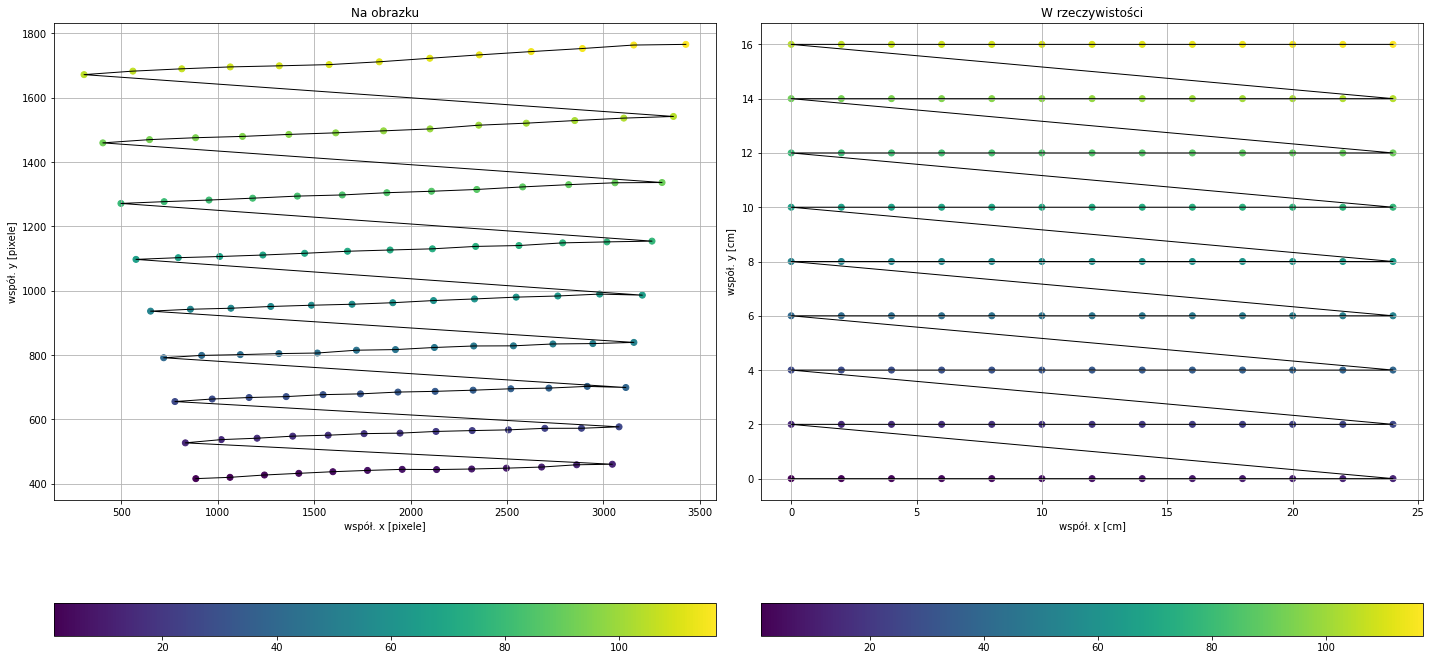

In [ ]:
x_real = np.linspace(0,26,13,endpoint=False)
y_real = np.linspace(0,18,9,endpoint=False)

corners_real = chessboard_reference_pts(nx=13,ny=9,dx=2.0)

plt.figure(figsize=[20.,10.])
plt.subplot(1,2,1)
plt.title('Na obrazku')
plt.grid(True)
plt.xlabel('współ. x [pixele]')
plt.ylabel('współ. y [pixele]')
plt.plot(corner_x,corner_y,linewidth=1,color='k')
sc1 = plt.scatter(corner_x,corner_y,c=npts)
plt.colorbar(sc1,orientation='horizontal')

plt.subplot(1,2,2)
plt.title('W rzeczywistości')
plt.grid(True)
plt.xlabel('współ. x [cm]')
plt.ylabel('współ. y [cm]')
plt.plot(corners_real[:,0,0],corners_real[:,0,1],linewidth=1,color='k')
sc2 = plt.scatter(corners_real[:,0,0],corners_real[:,0,1],c=npts)
plt.colorbar(sc2,orientation='horizontal')

plt.gcf().tight_layout()
plt.show()

#plt.figure(figsize=[10.,10.])
#plt.grid(True)
#plt.xlabel('współ. x [pixele]')
#plt.ylabel('współ. x [cm]')
#for i in range(corner_x.shape[0]//13):
#  plt.scatter(corner_x[i*13:(i+1)*13],x_real,label='linia {}'.format(i+1))
#plt.legend()
#plt.show()

(32768, 2)
[[ 300.      300.    ]
 [ 300.      314.0625]
 [ 300.      328.125 ]
 ...
 [3487.5    2057.8125]
 [3487.5    2071.875 ]
 [3487.5    2085.9375]]


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

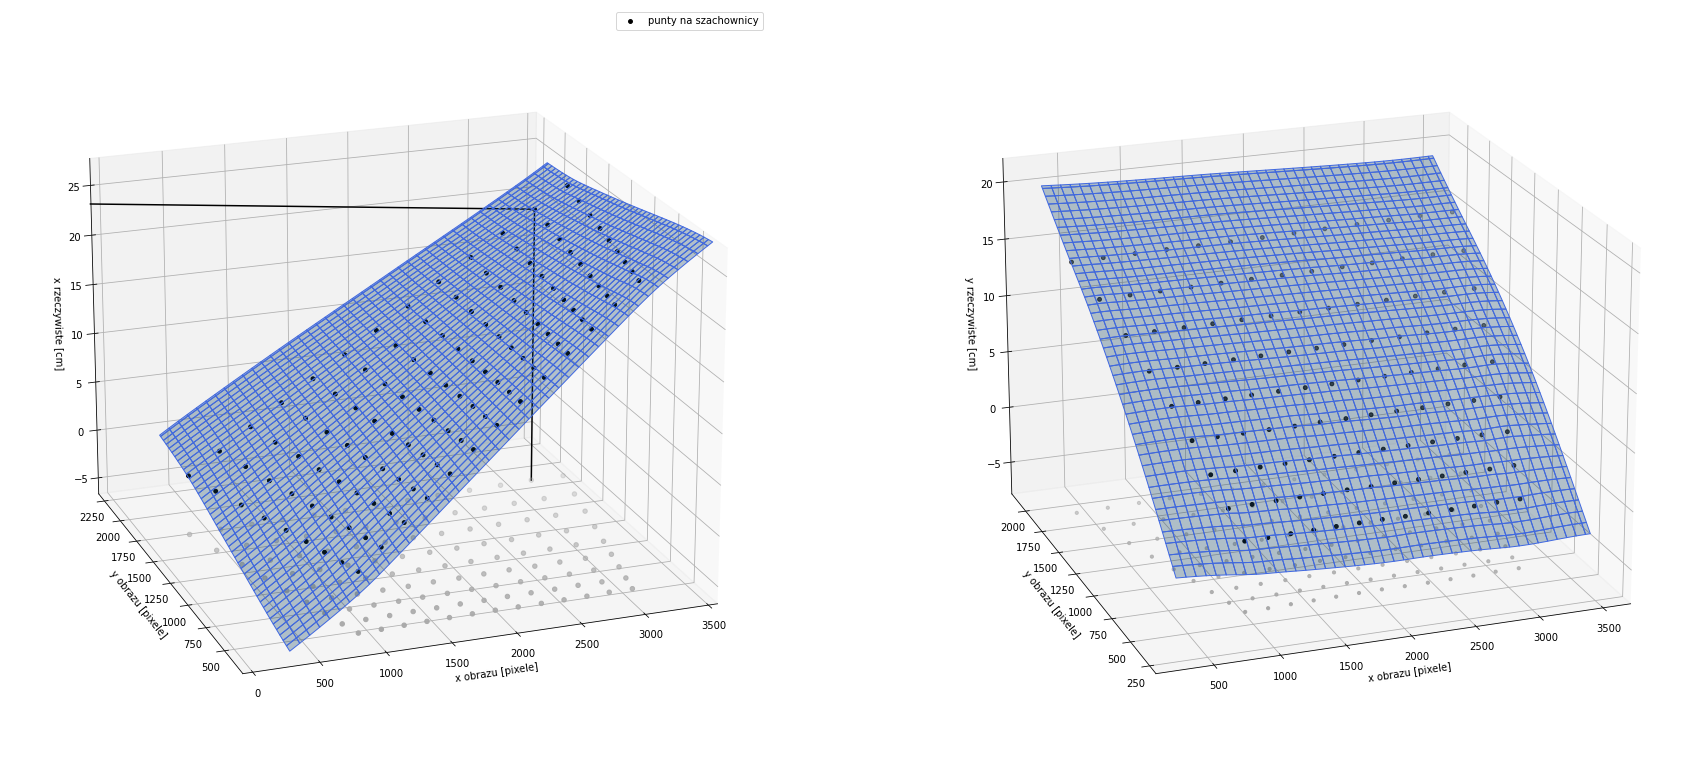

In [ ]:
x = np.linspace(300.,3500.,256,endpoint=False)
y = np.linspace(300.,2100.,128,endpoint=False)
X,Y = np.meshgrid(x,y,indexing='ij')                 # refined grid
pts_flatten = np.array([X.flatten(),Y.flatten()]).T  # collection of grid points

print(pts_flatten.shape)
print(pts_flatten)

z_min = -6.0
z_max = 27.0
z_zeros = np.zeros(corner_x.shape,dtype=corner_x.dtype)
z_zeros += z_min

# perform intepolation
corners_img = corners2
xRBF,yRBF = image_coords_interp(img_color,nx=13,ny=9,dx=2.0)  # function finding interpolation
X_real = np.reshape( xRBF(pts_flatten), X.shape)
Y_real = np.reshape( yRBF(pts_flatten), X.shape)

# plot X(x,y)
fig = plt.figure(figsize=[30.0,15.0])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlim([0.0,3500.0])
ax1.set_ylim([300.0,2300.0])
ax1.set_zlim([z_min,z_max])
ax1.set_xlabel('x obrazu [pixele]')
ax1.set_ylabel('y obrazu [pixele]')
ax1.set_zlabel('x rzeczywiste [cm]')
ax1.scatter(corner_x,corner_y,corners_real[:,0,0],color='k',s=15,label='punty na szachownicy',alpha=1.0)
ax1.scatter(corner_x,corner_y,z_zeros,color='darkgrey',s=20)
ax1.plot_surface(X,Y, X_real, edgecolor='royalblue', alpha=0.3)#,label='przybliżone odwzorowanie')
plt.legend()

nk = 115
ax1.plot([corner_x[nk],        corner_x[nk],                 0.0],
         [corner_y[nk],        corner_y[nk],              2500.0],
         [       z_min,corners_real[nk,0,0],corners_real[nk,0,0]], color='k')
ax1.view_init(elev=20, azim=250)

# plot Y(x,y)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('x obrazu [pixele]')
ax2.set_ylabel('y obrazu [pixele]')
ax2.set_zlabel('y rzeczywiste [cm]')
ax2.scatter(corner_x,corner_y,corners_real[:,0,1],color='k',s=15)
ax2.scatter(corner_x,corner_y,z_zeros,color='darkgrey',s=10)
ax2.plot_surface(X,Y,Y_real, edgecolor='royalblue', alpha=0.3)
ax2.view_init(elev=20, azim=250)

plt.show()

## Kalibracja kamery w OpenCV

To trochę inne zagadnienie, bo mając wiele zdjęć szachownicy możemy rozdzielić część transformacji wynikającą z rotacji i translacji kamery względem
od wad soczewki kamery powodujących dystorsje, aberracje itp. (idealna soczewka wykonywałaby prosty rzut równoległy, ale w rzeczywistości ten rzut jest zniekształcony).

In [ ]:
objpoints = [corners_real]; #objpoints.append(corners_real)
imgpoints = [corners2]; #imgpoints.append(corners2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)
print( mtx )
print( ret )

[[3.66638407e+03 0.00000000e+00 2.08028023e+03]
 [0.00000000e+00 4.41502601e+03 1.02195005e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(9, 19, 3983, 2215)


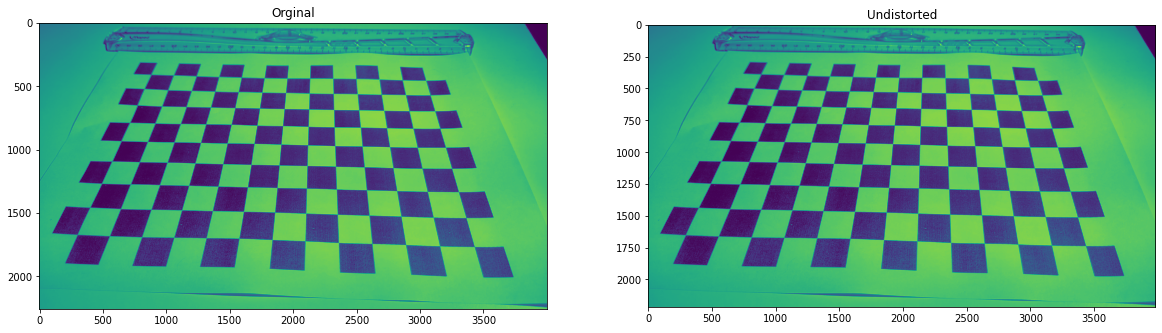

<class 'numpy.ndarray'> (117, 1, 2)


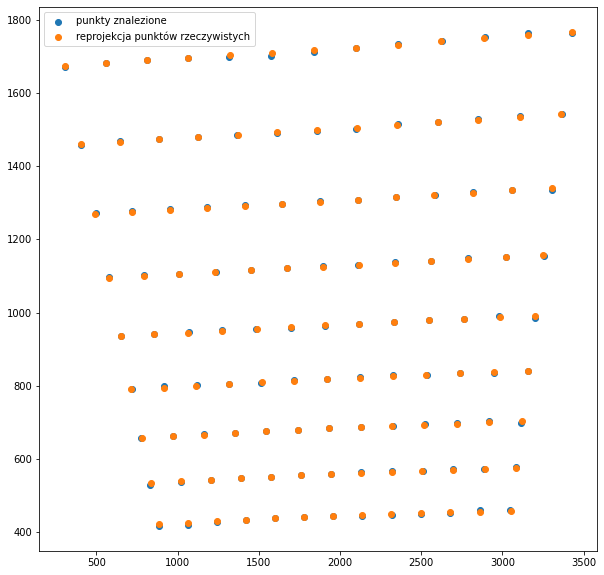

In [ ]:
w,h = img_gray.shape[::-1]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
print( mtx )
print( roi )

# undistort
dst = cv2.undistort(img_gray, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

plt.figure(figsize=[20.,10.])
plt.subplot(1,2,1)
plt.title('Orginal')
plt.imshow(img_gray)

plt.subplot(1,2,2)
plt.title('Undistorted')
plt.imshow(dst)
plt.show()

i=0
imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
print( type(imgpoints2), imgpoints2.shape )
plt.figure(figsize=[10.,10.])
plt.grid(True)
plt.scatter(corners2[:,0,0],corners2[:,0,1],label='punkty znalezione')
plt.scatter(imgpoints2[:,0,0],imgpoints2[:,0,1],label='reprojekcja punktów rzeczywistych')
plt.legend()
plt.show()


#cv2_imshow(dst)

In [ ]:
np.min(corners_real,0)

array([[0., 0., 1.]], dtype=float32)